# Style Transfer using GAN

## Problem Statement
To build a Generative adversarial model(modified U-Net) which can generate artificial MRI images of different contrast levels from existing MRI scans.

#### Background
Misdiagnosis in the medical field is a very serious issue but it’s also uncomfortably common to occur. Imaging procedures in the medical field requires an expert radiologist’s opinion since interpreting them is not a simple binary process ( Normal or Abnormal). Even so, one radiologist may see something that another does not. This can lead to conflicting reports and make it difficult to effectively recommend treatment options to the patient.

One of the complicated tasks in medical imaging is to diagnose MRI(Magnetic Resonance Imaging). Sometimes to interpret the scan, the radiologist needs different variations of the imaging which can drastically enhance the accuracy of diagnosis by providing practitioners with a more comprehensive understanding.

But to have access to different imaging is difficult and expensive. With the help of deep learning, we can use style transfer to generate artificial MRI images of different contrast levels from existing MRI scans. This will help to provide a better diagnosis with the help of an additional image.

## Project Pipeline
In this notebook, we will create T2 weighted images from T1 weighted MRI image and vice-versa.

Below sequence is followed for given problem statement:
1. Importing Libraries
2. Data Loading and Visualization
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF

## 1. Importing libraries

In [1]:
# Import all important libraries and instantiations
import pathlib
import os
from os import listdir
import numpy as np
from numpy import asarray
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils.vis_utils import plot_model
import imageio
import glob
from skimage.transform import resize

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jul  1 09:48:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2. Data Loading and Visualization

1. Data Loading
2. Data Visualization

### 2.1. Data Loading

In [5]:
# Let's write a function for loading and resizing images
def load_mri_images(path, size=(256,256)):
    list_of_data = list()
    
    for filename in listdir(path):     
        pixels = load_img(path +'/'+ filename, target_size=size)
        pixels = img_to_array(pixels) # convert to numpy array
        list_of_data.append(pixels) # storing the data for further processing
    return asarray(list_of_data)

In [6]:
# load dataset from tr1 folder i.e. TR1 MRI images

tr1_data = load_mri_images('/content/drive/MyDrive/GAN/Tr1/TrainT1') 
tr1_data = tf.image.rgb_to_grayscale(tr1_data) #convert to grayscale
tr1= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_data))
tr1

<TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)>

In [7]:
# load dataset from tr2 folder i.e. TR2 MRI images

tr2_data = load_mri_images('/content/drive/MyDrive/GAN/Tr2/TrainT2')
tr2_data = tf.image.rgb_to_grayscale(tr2_data) #convert to grayscale
tr2= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_data))
tr2

<TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)>

### 2.2. Data Visualization

#### Visualizing TR1 MRI 
- Sample image from dataset
- Shape of TR1 dataset

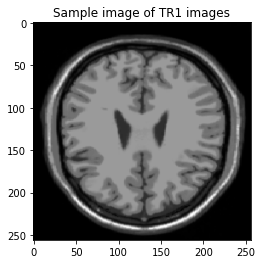

In [8]:
plt.title('Sample image of TR1 images')
plt.imshow(tr1_data[0].numpy().reshape(256,256), cmap='gray')

In [9]:
tr1_data.shape

TensorShape([43, 256, 256, 1])

#### Visualizing TR2 MRI 
- Sample image from dataset
- Shape of TR2 dataset

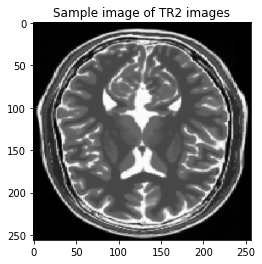

In [10]:
plt.title('Sample image of TR2 images')
plt.imshow(tr2_data[0].numpy().reshape(256,256), cmap='gray')

In [11]:
tr2_data.shape

TensorShape([46, 256, 256, 1])

## 3. Data Preprocessing

1. Create a function to process your images with normalisation
2. Apply the function to both the datasets
3. Visualise the MRI images after processing

In [12]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

### 3.1. Normalization

In [13]:
# Creating function for normalizing the images to [-1, 1]
def normalize(image):
    image =  tf.cast(image, tf.float32)
    image= (image / 127.5) - 1 
    return image

In [14]:
# Creating function for pre-processing of images along with normalization
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)   
    return image

### 3.2. Preprocessing TR1 and TR2 datasets

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tr1 = tr1.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tr2 = tr2.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

### 3.3. Visualise the MRI images after processing

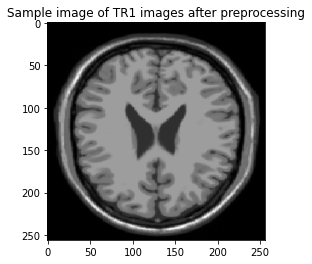

In [17]:
# Visualizing TR1
plt.title('Sample image of TR1 images after preprocessing')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

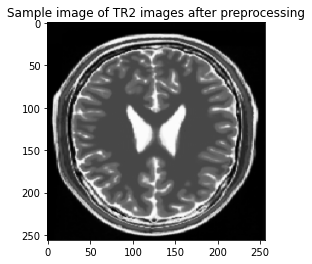

In [18]:
# Visualizing TR2
plt.title('Sample image of TR2 images after preprocessing')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## 4. Model Building

1. Instance Normalization
2. Downsampling, Upsampling and Unet
3. Generator Building using Unet
4. Discriminator Building

### 4.1. Instance Normalization
Instance Normalization are specially used with Style Transfer, where Separate Normalization is performed for each sample we perform channelwise Normalization.

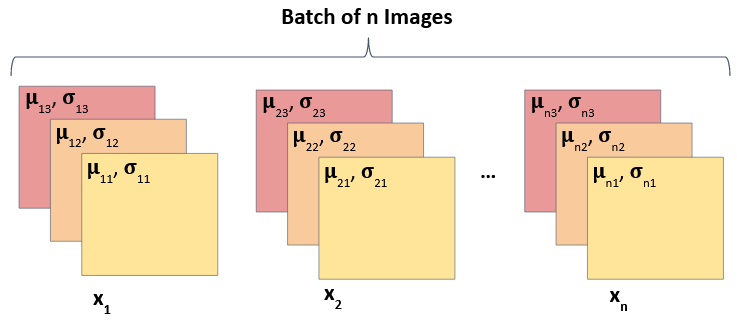

In [19]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

### 4.2(a). Downsampling

Downsampling is performed using the Convolution, leading to reduce in dimensions.

In [20]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

### 4.2(b). Upsampling

Upsampling is a result of Transposed Convolution, where dimension of image are increased.

In [21]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

### 4.2(c). Unets

Unets takes Image as an input and translate it into another Image.

To do this they first use Downsampling on Input Image to learn the latent characteristics of Input Image and then use Upsampling to use this knowledge to Translate it into another Image.

Let's understand it through the below image.

<center>

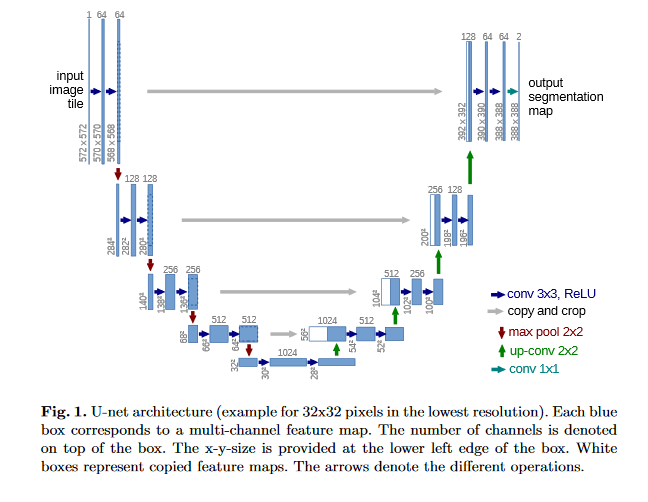

</center>

In [22]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
   
    down_stack = [
      downsample(64, 4, apply_norm=False), 
      downsample(128, 4), 
      downsample(256, 4),  
      downsample(512, 4),  
      downsample(512, 4), 
      downsample(512, 4),  
      downsample(512, 4),  
      downsample(512, 4),  
    ]#created a stack of downsample models
                  
    up_stack = [
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4),  
      upsample(256, 4),  
      upsample(128, 4),  
      upsample(64, 4),  
        ] #created a stack of upsample models
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') 
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

### 4.3. Generator Building using UNet
Generator is a Unet Network here since We want to translate One type of Image (digit 4) into Another type of Image (digit 9).

In [23]:
generator_g = unet_generator() #initialise the generator
generator_f = unet_generator() #initialise the generator

Let's also visualize one of our Generator Models since Both our Generators have same architecture.

In [24]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   1024        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131328      ['sequential[0][0]']             
                                128)                                                          

### 4.4. Discriminator Building

Discriminator is a traditional CNN, which we use to classify the Images. It only uses Downsampling hence.

Both Discriminators have same architecture

In [25]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4,  False)(x)  #code to downsample X
    down2 = downsample(128, 4)(down1)     #code to downsample down1
    down3 = downsample(256, 4)(down2)     #code to downsample down2
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  
    return tf.keras.Model(inputs=inp, outputs=last) #model using input & output layer

In [26]:
discriminator_x = discriminator() #initialise the discriminator
discriminator_y = discriminator() #initialise the discriminator

Have a look at Discriminator's architecture. We can see that The Dimensions are reducing overall at the end since it's a classifier and only Convolution layers are being used.

In [27]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, None, None, 1)]   0         
                                                                 
 sequential_30 (Sequential)  (None, None, None, 64)    1024      
                                                                 
 sequential_31 (Sequential)  (None, None, None, 128)   131328    
                                                                 
 sequential_32 (Sequential)  (None, None, None, 256)   524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, None, None, 256)  0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, None, None, 512)   2097152   
                                                           

## 5. Model Training

1. Declare Loss type
2. Calculate Discriminator Loss
3. Calculate Generator Loss
4. Cycle Loss
5. Identity Loss
6. Optimizer
7. Checkpoint Initialization
8. Training Flow

Checking output of Untrained Generator models which should be a random noise

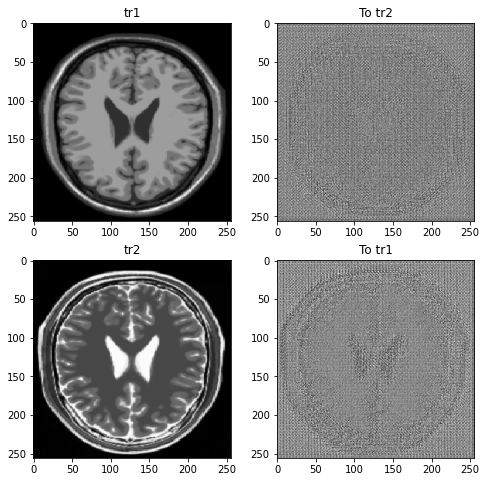

In [28]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

### 5.1. Declare Loss Type

Since Our Discriminator is a classifier, hence using Binary Cross Entropy(BCE)

In [29]:
LAMBDA = 10

In [30]:
# Using Binarycross entropy with logits true
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 5.2. Calculate Discriminator Loss

It consists of two types of losses
1.    Loss on Real Data
2.    Loss on Fake Data

In [31]:
# calculating discriminator loss by summing the real and generated
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real) 
    generated_loss = loss_obj(tf.zeros_like(generated), generated) 
    total_disc_loss = real_loss + generated_loss 
    return total_disc_loss * 0.5

### 5.3. Calculate Generator Loss

It has only one type of loss - Discriminator Loss on Generated data

In [32]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

### 5.4. Cycle Loss

When we use both of Generators sequentially on a Input Image, we get Cycle Image and the L1 Loss between these two is called Cycle Loss.

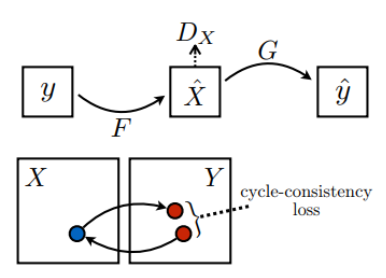

In [33]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) 
    return LAMBDA * loss1

### 5.5. Identity Loss

When we provide input image to the Generator such that no translation is needed because the Image is already transformed. Here also we take L1 Loss between Input and Output Image.

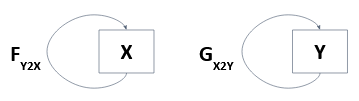

In [34]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

### 5.6. Optimizer

We use Adam Optimizer to update weights which is a good optimizer to achieve quick learning.

In [35]:
# Optimizer with learning rate 2e-4 for generator and discriminator
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
EPOCHS = 500

### 5.7. Checkpoint Initialization

Initialize checkpoints to save models

In [37]:
checkpoint_path = './checkpoints'  
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


Function to show Images output by Generators while Training

In [38]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input:T1', 'Predicted: T1->T2 ', 'Input: T2', 'Predicted: T2->T1']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/GAN/output/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Below Function performs one Flow of Batch Training <p>
Notice that Identity Loss and Cycle Loss are only used in training Generator and not Discriminator

Sequence of Training Flow

1.   Generate Fake Y and Cycled X
2.   Generate Fake X and Cycled Y
3.   Generate Fake Images through G and F for Identity Loss.
4.   Calculate Discriminator Loss for Disc X and Disc Y on Fake Data for Generator Training.
5.   Calculate Generator Loss on Discriminator.
6.   Calculate Cycled Loss on Cycled Images from step 1 and 2.
7.   Calculate Total Generator Loss - Disc Loss + Cycled Loss + Identity Loss
8.   Calculate Discriminator Loss on both Fake and Real Images for Disc X and Y for Disc Training.
9.   Calculate the Gradients and update the weight and bias of models.

In [39]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)  # code to generate images using Generator_g on real_x
        cycled_x = generator_f(fake_y, training=True) # code to generate images susiing Generator_f on fake_y
        
        fake_x =  generator_f(real_y, training=True) # code to generate images using Generator_f on real_y
        cycled_y = generator_g(fake_x, training=True) # code to generate images using Generator_g on fake_x
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True) # code to generate images using Generator_f on real_x
        same_y = generator_g(real_y, training=True) # code to generate images using Generator_g on real_y
        
        disc_real_x =  discriminator_x(real_x, training=True) # code to discriminate images using Discriminator_x on real_x
        disc_real_y = discriminator_y(real_y, training=True) # code to discriminate images using Discriminator_y on real_y
        
        disc_fake_x = discriminator_x(fake_x, training=True) # code to discriminate images using Discriminator_x on fake_x
        disc_fake_y = discriminator_y(fake_y, training=True) #code to discriminate images using Discriminator_y on fake_y
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) # calculating the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x) # calculating the generator_loss for disc_fake_X 
        
        #calculate the total cycle loss
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
         
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # calculating the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # calculating the discriminator_loss foor disc_fake_y wrt disc_real_y
        
    # Calculating the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables) 
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables) 
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
    
    # Applying the gradients to the optimizer
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables)) #write your code here
    

### Train the CycleGAN Model for several Epochs
Loop training function for number of epochs and also show the output at each step. <p>
Note how Generators are getting better at producing realistic images epoch by epoch

In [40]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, generator_f, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

Output hidden; open in https://colab.research.google.com to view.

### 6. Generating a GIF for visualization of Results
Notice the Quality of results we are getting.

In [41]:
anim_file = '/content/drive/MyDrive/GAN/cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/drive/MyDrive/GAN/output/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [42]:
pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-mdp2g9i_
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-mdp2g9i_
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180247 sha256=45ca091883f92abac25b36b8051bbefa45df47edc7af3b2cc42dc9ee423338f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-0yc81cc4/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [43]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.